In [1]:
fasta_file = '../data/dengue.fasta'#RSV2-reduced.fasta'
date_regex = '[0-9]{2}$'#[^s]*$'
out_dir = 'out'

# Topology inference

## Unrooted topology

In [2]:
import topology_inference

nj_tree = topology_inference.infer_topology_neighbor_joining(fasta_file, 'fasta', out_dir)
raxml_tree, raxml_params = topology_inference.infer_topology_raxml(fasta_file, 'fasta', out_dir, subst_model='HKY', run_raxml=False, estimate_frequencies=True)
raxml_params

{'alpha': 0.02,
 'rates': {'ac': 1.0,
  'ag': 20.065921,
  'at': 1.0,
  'cg': 1.0,
  'ct': 20.065921,
  'gt': 1.0},
 'frequencies': [0.293402, 0.20491, 0.256425, 0.245264]}

## Rooting

In [3]:
rooted_tree, estimated_rate = topology_inference.root_topology(fasta_file, 'fasta', out_dir, date_regex, raxml_tree)
estimated_rate

0.0007445419620389046

In [4]:
from importlib import reload
reload(topology_inference)

analysis_tree = topology_inference.convert_tree(rooted_tree, 'nexus', 'newick', strip_data=True, allow_zero_branches=False, epsilon=1e-1)
analysis_tree

'out/lsd-tree.date.newick'

In [5]:
estimated_pop_size = topology_inference.estimate_pop_size(rooted_tree, 'nexus')
estimated_pop_size

88.494338

# Strict clock analysis

## Tensorflow model

### Prior

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import treeflow.coalescent

from importlib import reload
reload(treeflow.coalescent)

import treeflow.tree_processing
import treeflow
import treeflow.libsbn

cast = lambda x: tf.convert_to_tensor(x, dtype=treeflow.DEFAULT_FLOAT_DTYPE_TF)
inst = treeflow.libsbn.get_instance(analysis_tree)
tree_info = treeflow.libsbn.get_tree_info(inst)
tree = tree_info.tree
topology = treeflow.tree_processing.update_topology_dict(tree['topology'])
taxon_count = (tree['heights'].shape[0] + 1) // 2
sampling_times = cast(tree['heights'][:taxon_count])

prior = tfd.JointDistributionNamed(dict(
    clock_rate=tfd.LogNormal(loc=cast(0.0), scale=cast(3.0)),
    pop_size=tfd.LogNormal(loc=cast(0.0), scale=cast(3.0)),
    tree=lambda pop_size: treeflow.coalescent.ConstantCoalescent(taxon_count, pop_size, sampling_times)
))
prior.log_prob(tree=tree, clock_rate=estimated_rate, pop_size=estimated_pop_size)

/mnt/c/chris/git/treeflow/treeflow/coalescent.py:76: UserWarning: Dummy sampling
  warnings.warn('Dummy sampling')


<tf.Tensor: shape=(), dtype=float64, numpy=-85.11558897667112>

### Likelihood

In [7]:
import treeflow.beagle
import treeflow.substitution_model
import treeflow.sequences

subst_model = treeflow.substitution_model.HKY()
likelihood, instance = treeflow.beagle.log_prob_conditioned_branch_only(
    fasta_file,
    subst_model,
    raxml_params['frequencies'],
    kappa=raxml_params['rates']['ag'],
    newick_file=analysis_tree,
    rescaling=False,
    inst=inst)

likelihood(treeflow.sequences.get_branch_lengths(treeflow.tree_processing.tree_to_tensor(tree)) * estimated_rate)

<tf.Tensor: shape=(), dtype=float64, numpy=-3854.0749300647303>

In [8]:
import treeflow.tree_processing
wrapped_likelihood = lambda z: likelihood(treeflow.sequences.get_branch_lengths(z['tree']) * tf.expand_dims(z['clock_rate'], -1))
log_prob = lambda **z: (prior.log_prob(z) + wrapped_likelihood(z))
log_prob(tree=treeflow.tree_processing.tree_to_tensor(tree), clock_rate=cast(estimated_rate), pop_size=cast(estimated_pop_size))

<tf.Tensor: shape=(), dtype=float64, numpy=-3939.1905190414013>

## Variational approximation

In [18]:
import treeflow.model

from importlib import reload
reload(treeflow.tree_transform)


approx_name = 'q'

def rebuild_approx():
    prior_approx_dict = treeflow.model.construct_prior_approximation(prior, approx_name=approx_name, init_mode=dict(
        clock_rate=cast(estimated_rate),
        pop_size=cast(estimated_pop_size)
    ))
    tree_approx = treeflow.model.construct_tree_approximation(tree=tree, approx_name=approx_name, inst=instance)
    return tfd.JointDistributionNamed(dict(tree=tree_approx, **prior_approx_dict))
mean_field = rebuild_approx()
init_approx_sample = mean_field.sample()
log_prob(**init_approx_sample), mean_field.log_prob(init_approx_sample), [(var.name, var.shape) for var in mean_field.trainable_variables]

(<tf.Tensor: shape=(), dtype=float64, numpy=-4376.538620907924>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-28.267329985983192>,
 [('q_tree_loc:0', TensorShape([16])),
  ('q_tree_scale:0', TensorShape([16])),
  ('q_pop_size_loc:0', TensorShape([])),
  ('q_pop_size_scale:0', TensorShape([])),
  ('q_clock_rate_loc:0', TensorShape([])),
  ('q_clock_rate_scale:0', TensorShape([]))])

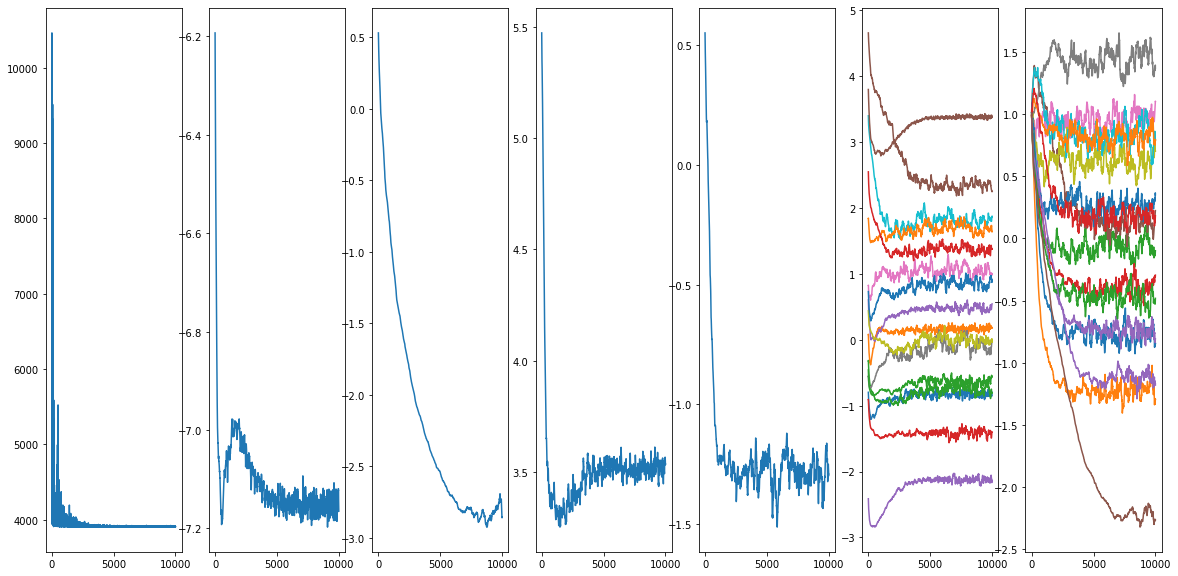

In [36]:
import matplotlib.pyplot as plt

loss, params = tfp.vi.fit_surrogate_posterior(
    log_prob,
    mean_field,
    tf.optimizers.Adam(learning_rate=0.01),
    10000,
    trace_fn=lambda x: (x.loss, x.parameters))
fig, axs = plt.subplots(ncols=len(params) + 1, figsize=(20, 10))
axs[0].plot(loss)
for ax, param in zip(axs[1:], params):
    ax.plot(param)

## HMC Inference

In [38]:
init_leaf_heights = init_approx_sample['tree']['heights'][:taxon_count]
init_node_heights = init_approx_sample['tree']['heights'][taxon_count:]
init_parent_indices = init_approx_sample['tree']['topology']['parent_indices']

def heights_to_tree(node_heights):
    new_leaf_shape = tf.concat([tf.shape(node_heights)[:-1], tf.shape(init_leaf_heights)], axis=0)
    init_leaf_heights_broadcasted = tf.broadcast_to(init_leaf_heights,  new_leaf_shape)
    heights = tf.concat([init_leaf_heights_broadcasted, node_heights], axis=-1)
    
    new_parent_indices_shape = tf.concat([tf.shape(node_heights)[:-1], tf.shape(init_parent_indices)], axis=0)
    parent_indices_broadcasted = tf.broadcast_to(init_parent_indices, new_parent_indices_shape)
    
    return dict(heights=heights, topology=dict(parent_indices=parent_indices_broadcasted))

hmc_target = lambda heights, pop_size, clock_rate: log_prob(tree=heights_to_tree(heights), pop_size=pop_size, clock_rate=clock_rate)
hmc_target = tf.function(hmc_target)
hmc_target(init_node_heights, init_approx_sample['pop_size'], init_approx_sample['clock_rate'])

<tf.Tensor: shape=(), dtype=float64, numpy=-4376.538620907924>

In [39]:
init_samples = mean_field.sample(3)
init = init_samples['tree']['heights'][..., taxon_count:], init_samples['pop_size'], init_samples['clock_rate']

In [43]:
height_bijector = mean_field.model['tree'].height_distribution.node_height_distribution.bijector

def sample_posterior(num_chains=3, num_results=1000, num_burnin_steps=100):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=hmc_target, num_leapfrog_steps=3, step_size=0.1)
    unconstraining_bijectors = [height_bijector, tfp.bijectors.Exp(), tfp.bijectors.Exp()]
    transformed_kernel = tfp.mcmc.TransformedTransitionKernel(hmc, unconstraining_bijectors)
    #kernel = tfp.mcmc.SimpleStepSizeAdaptation(transformed_kernel, int(num_burnin_steps*0.8))
    kernel=transformed_kernel
    init_samples = mean_field.sample(num_chains)
    init = [init_samples['tree']['heights'][..., taxon_count:], init_samples['pop_size'], init_samples['clock_rate']]
    samples, acceptances = tfp.mcmc.sample_chain(num_results, init,
                                                    kernel=kernel, num_burnin_steps=num_burnin_steps,
                                                    trace_fn=lambda s, k: k.inner_results.is_accepted
                                                   )
    acceptance_probs = tf.reduce_mean(tf.cast(acceptances, tf.float32), axis=0)
    return samples, acceptance_probs

num_chains = 3
samples, acceptance_probs = sample_posterior(num_chains=num_chains)
acceptance_probs

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.1  , 0.133, 0.305], dtype=float32)>

In [49]:
samples[0][..., -1]

<tf.Tensor: shape=(1000, 3), dtype=float64, numpy=
array([[66.63254808, 67.70250683, 77.11730165],
       [66.63254808, 67.70250683, 76.9321952 ],
       [66.63254808, 67.70250683, 73.34993609],
       ...,
       [75.22465874, 70.77159256, 66.20597424],
       [75.22465874, 70.77159256, 66.20597424],
       [75.22465874, 70.30477488, 67.82748415]])>

In [48]:
import seaborn as sns
import pandas as pd

pd.DataFrame({ 'root_height': samples[0][..., -1]})

ValueError: If using all scalar values, you must pass an index

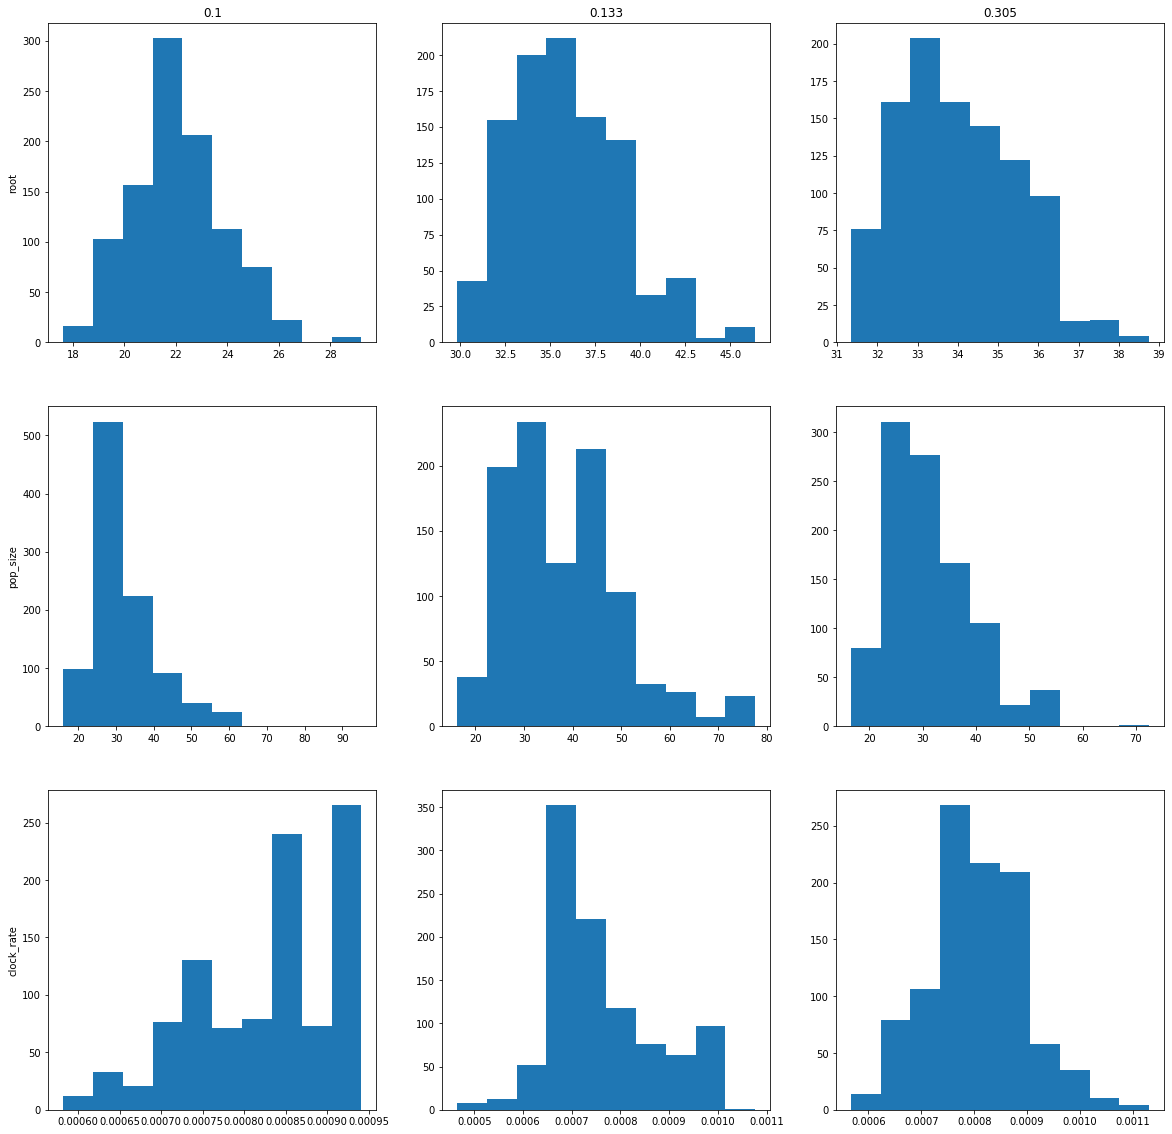

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for var, var_samples, row in zip(['root', 'pop_size', 'clock_rate'], samples, axs):
    row[0].set_ylabel(var)
    for j, row in enumerate(row):
        row.hist(var_samples[:, -1, j] if var == 'root' else var_samples[:, j])
        
for j in range(3):
    axs[0, j].set_title(acceptance_probs[j].numpy())

## Model fitting

We use `tf.summary` so we can monitor model fitting with Tensorboard.

In [ ]:
with tf.GradientTape(persistent=True) as t:
    for var in mean_field.trainable_variables:
        t.watch(var)
var_names = [var.name for var in t.watched_variables()]
tree_loc_index = var_names.index('q_tree_loc:0')
tree_scale_index = var_names.index('q_tree_scale:0')

In [ ]:
import matplotlib.pyplot as plt
import datetime
import pathlib
import os

run_id = datetime.datetime.now().strftime('run %Y-%m-%d %H:%M:%S')
log_dir = str(pathlib.Path('out') / 'tensorflow-logs' / run_id)
os.mkdir(log_dir)
writer = tf.summary.create_file_writer(log_dir, flush_millis=100)

def trace_fn(traceable_quantities):
    with writer.as_default():
        tf.summary.scalar('loss', tf.reduce_sum(traceable_quantities.loss), step=traceable_quantities.step)
        tf.summary.scalar('root_loc', traceable_quantities.parameters[tree_loc_index][-1], step=traceable_quantities.step)
        tf.summary.scalar('root_scale', traceable_quantities.parameters[tree_scale_index][-1], step=traceable_quantities.step)
    return traceable_quantities.loss, traceable_quantities.parameters

mean_field = rebuild_approx()
optimizer = tf.optimizers.SGD(learning_rate=0.001)
res = tfp.vi.fit_surrogate_posterior(log_prob,
                                     mean_field,
                                     optimizer,
                                     20000,
                                     trace_fn=trace_fn,
                                     trainable_variables=mean_field.trainable_variables)

plt.plot(res[0].numpy())

### Check convergence

In [ ]:
fig, axs = plt.subplots(ncols=len(var_names), figsize=(16, 4))  

for ax, vals, name in zip(axs, res[1], var_names):
    ax.plot(vals)
    ax.set_title(name)